In [275]:
import os
import numpy as np
import torch as t
import torchvision
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns

from torchvision import transforms
from torchvision.transforms import v2
from tqdm import tqdm
from numpy.lib.stride_tricks import sliding_window_view


In [276]:
def reshaping_data(u, dataset_name, norm_value):
    u = np.array(u)
    # Permuting the dimensions of the input data to (CHANNELS, HEIGHT, WIDTH).
    u = u.reshape((1, *u.shape))
    return u / norm_value


def preprocess(data, dataset_name, num_classes, dataset_cap, norm_value=255., device='cpu', isTrain=True):
    _set = []
    distribution = t.zeros((num_classes,), dtype=t.int32)
    I = t.eye(num_classes, dtype=t.float32, device=device)
    display_counter = np.zeros((num_classes,), dtype=np.int32)

    for u, v in tqdm(data, desc=f'Preprocessing {"Training" if isTrain else "Evaluating"} Data: ', colour='green'):
        if dataset_name == 'letters':
            v = v - 1

        # Limit the number of classes for testing purposes.
        if v < num_classes:
            label = I[v]
            if display_counter[v] != 0:
                plt.imshow(u)
                plt.show()
                display_counter[v] += 1

            if isTrain:
                if distribution[v] < dataset_cap // num_classes:
                    u = reshaping_data(u, dataset_name, norm_value)
                    _set.append([u, label])
                    distribution[v] += 1
            else:
                u = reshaping_data(u, dataset_name, norm_value)
                _set.append([u, label])

    return _set, distribution


In [277]:
def load_dataset(dataset_name, num_classes, dataset_cap, training_batch_size, evaluating_batch_size,
                 norm_value: float = 255., device='cpu', augmenting=False):
    root = '../../data'
    exclude_list = ['fashion', 'mnist']
    dataset_mapping = {
        'fashion': torchvision.datasets.FashionMNIST,
        'mnist': torchvision.datasets.MNIST,
        'emnist': torchvision.datasets.EMNIST
    }

    transforms_list = []
    if dataset_name not in exclude_list:
        transforms_list = [
            lambda img: v2.functional.rotate(img, -90), 
            lambda img: v2.functional.hflip(img), 
        ]

    if augmenting:
        transforms_list.append(transforms.RandomAffine(degrees=15, translate=(0.3, 0.3), scale=(0.5, 1.1), shear=3))

    # Aside of EMNIST dataset need to be rotated and flipped, while MNIST already in the correct orientation.
    # Set `augmenting` to `True` to apply random affine transformations to the training data.
    if dataset_name in exclude_list:
        datasetTrain = dataset_mapping[dataset_name](root, train=True, download=True, transform=torchvision.transforms.Compose(transforms_list))
        datasetTest = dataset_mapping[dataset_name](root, train=False, download=True)
    else:
        datasetTrain = dataset_mapping['emnist'](
            root, download=True, split=dataset_name, train=True,
            transform=torchvision.transforms.Compose(transforms_list)
        )
        datasetTest = dataset_mapping['emnist'](
            root, download=True, split=dataset_name, train=False,
            transform=torchvision.transforms.Compose(transforms_list)
        )

    trainingSet, trainingDist = preprocess(datasetTrain, dataset_name, num_classes, dataset_cap, norm_value, device, True)
    evaluatingSet, _ = preprocess(datasetTest, dataset_name, num_classes, len(datasetTest), norm_value, device, False)

    # Randomly shuffle the training and evaluating sets.
    for _ in range(100):
        random.shuffle(trainingSet)
        random.shuffle(evaluatingSet)

    # Batching the training and evaluating sets.
    trainingXBatches, trainingYBatches = [], []
    xBatch, yBatch = [], []
    for x, y in trainingSet:
        xBatch.append(x)
        yBatch.append(y)

        if len(xBatch) == training_batch_size:
            xBatch = np.stack(xBatch, axis=0)
            yBatch = t.stack(yBatch, dim=0)

            trainingXBatches.append(xBatch)
            trainingYBatches.append(yBatch)

            xBatch = []
            yBatch = []

    evaluatingXBatches, evaluatingYBatches = [], []
    xBatch, yBatch = [], []
    for x, y in evaluatingSet:
        xBatch.append(x)
        yBatch.append(y)

        if len(xBatch) == evaluating_batch_size:
            xBatch = np.stack(xBatch, axis=0)
            yBatch = t.stack(yBatch, dim=0)

            evaluatingXBatches.append(xBatch)
            evaluatingYBatches.append(yBatch)

            xBatch = []
            yBatch = []

    return (trainingXBatches, trainingYBatches), (evaluatingXBatches, evaluatingYBatches), trainingDist


In [278]:
vmax = 2
vmin = -2


In [279]:
def norm(x):
    return x / (t.sqrt(t.mean(x ** 2, dim=-1, keepdim=True)) + 1e-12)


class StateLayer(t.nn.Module):
    def __init__(self, input_features, output_features, train=True, update_rate=1e-4, batch_size=500, device='cpu', init_threshold=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.device = device
        self.update_rate = update_rate
        self.batch_size = batch_size
        self.input_features = input_features
        self.output_features = output_features
        self.rehearsal_idx = 0

        self.a = np.sqrt(6 / (input_features + output_features))

        # Both `w` & `b` matrices are initialized using Xavier's initialization.
        self.w = t.tensor(np.random.uniform(-self.a, self.a, (input_features, output_features)), dtype=t.float32, device=self.device)
        self.b = t.tensor(np.random.uniform(-self.a, self.a, (input_features, output_features)), dtype=t.float32, device=self.device)

        # `s` is the state of each layer.
        self.s = t.zeros((batch_size, output_features), device=self.device, dtype=t.float32)

        # `partition_point` is where to partition in the heaviside function, default is 0.
        self.partition_point = t.tensor([0], dtype=t.float32, device=self.device)

    def forward(self, u):
        w_ = self.w.unsqueeze(0)
        b_ = self.b.unsqueeze(0)
        u = u.unsqueeze(2)
        s = self.s[:, None, :]

        potential = (-u + s) ** 4
        mask = t.heaviside(potential - b_, self.partition_point)  # Masking the activity of each synapses based on action potential.
        self.s = t.tanh((mask * w_ * u).sum(1))

        if self.training:
            magnitude = norm((potential * (2 * mask - 1)).sum(0))

            # Updating the weights and biases based on the magnitude of the potential between neurons and their sign.
            self.w += magnitude * t.sign(self.w) * self.update_rate
            self.b -= 4 * magnitude * t.sign(self.b) * self.update_rate

            # Rescaling the weights to the range [-1, 1].
            w_min = t.min(self.w)
            w_max = t.max(self.w)
            self.w = ((vmax - vmin) * (self.w - w_min) / (w_max - w_min)) + vmin

        return self.s.clone().detach()


In [280]:
class StateNetwork():
    def __init__(self, input_features, image_shape, hidden_blocks, update_rates, batch_size, num_rehearsal=10, device='cpu',
                 decoder_learning_rate=1e-2, input_shape=(28, 28), kernel_shape=(4, 4), stride=(4, 4), num_classes=10,
                 num_channels=1, training=True):
        self.device = device
        self.image_shape = image_shape
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.kernel_shape = kernel_shape
        self.stride = stride
        self.input_features = input_features
        self.num_channels = num_channels
        self.hidden_blocks = hidden_blocks
        self.num_classes = num_classes
        self.training = training
        self.num_rehearsal = num_rehearsal

        self.n_steps = ((image_shape[0] - kernel_shape[0]) // stride[0] + 1) * ((image_shape[1] - kernel_shape[1]) // stride[1] + 1)
        self.records = t.zeros((batch_size, self.n_steps * hidden_blocks[-1]), device=self.device, dtype=t.float32)
        self._layers = [
            StateLayer(input_features * self.num_channels, hidden_blocks[0], init_threshold=2, 
                       batch_size=batch_size, update_rate=update_rates[0], device=self.device),
            *[
                StateLayer(hidden_blocks[i], hidden_blocks[i + 1], init_threshold=2, 
                           batch_size=batch_size, update_rate=update_rates[i + 1], device=self.device) 
                for i in range(len(hidden_blocks) - 1)
            ]
        ]

        self.layers = t.nn.Sequential(*self._layers)
        self.decoder = t.nn.Sequential(
            [t.nn.Linear(self.n_steps * self.hidden_blocks[-1], 256) if not self.is_same_shape() 
             else t.nn.Linear(sum(self.hidden_blocks), 256)][0],
            t.nn.ReLU(),
            t.nn.Linear(256, self.num_classes),
            t.nn.Softmax(dim=1)
        ).to(device)
        self.optim = t.optim.Adam(self.decoder.parameters(), lr=decoder_learning_rate)
        self.criterion = t.nn.MSELoss()

    def is_same_shape(self):
        if self.input_shape[0] == self.image_shape[0] and self.input_shape[1] == self.image_shape[1]:
            return True
        return False

    def get_encoder_params(self):
        num_params = 0
        for layer in self.layers:
            num_params += layer.w.shape[0] * layer.w.shape[1]
        return num_params * 2

    def unfreeze_forward_layer(self, batch_size):
        self.batch_size = batch_size
        for i in range(len(self.layers)):
            self.layers[i].s = t.zeros((batch_size, self._layers[i].s.shape[1]), device=self.device)
            self.layers[i].batch_size = batch_size
            self.layers[i].training = True

    def unfreeze_decoder(self):
        self.training = True
        self.decoder.train()

    def freeze_forward_layer(self, batch_size):
        self.batch_size = batch_size
        for i in range(len(self.layers)):
            self.layers[i].s = t.zeros((batch_size, self._layers[i].s.shape[1]), device=self.device)
            self.layers[i].batch_size = batch_size
            self.layers[i].training = False

    def freeze_decoder(self):
        self.training = False
        self.decoder.eval()

    def train_(self, batch_size):
        self.batch_size = batch_size
        self.records = t.zeros((batch_size, self.n_steps * self.hidden_blocks[-1]), device=self.device, dtype=t.float32)
        self.unfreeze_forward_layer(batch_size)
        self.unfreeze_decoder()

    def eval_(self, batch_size):
        self.batch_size = batch_size
        self.records = t.zeros((batch_size, self.n_steps * self.hidden_blocks[-1]), device=self.device, dtype=t.float32)
        self.freeze_forward_layer(batch_size)
        self.freeze_decoder()

    def clear_memo(self):
        self.records *= 0.
        for i in range(len(self.layers)):
            self.layers[i].s *= 0.
            self.layers[i].rehearsal_idx = 0

    def forward(self, u, v=None):
        with t.no_grad():
            if self.is_same_shape():
                for idx in range(self.num_rehearsal):
                    self.layers(t.tensor(u.reshape((self.batch_size, -1)), device=self.device, dtype=t.float32))
            else:
                slides = sliding_window_view(u, self.kernel_shape, (2, 3))[:, :, ::self.stride[0], ::self.stride[1]]\
                    .reshape((self.batch_size, self.num_channels, self.n_steps, self.input_features))
                for block_idx in range(self.n_steps):
                    u = t.tensor(slides[:, :, block_idx, :].reshape((self.batch_size, -1)), device=self.device, dtype=t.float32)
                    for _ in range(self.num_rehearsal):
                        out = self.layers.forward(u)

                    if block_idx + 1 < self.n_steps:
                        self.records[:, block_idx * self.hidden_blocks[-1]: (block_idx + 1) * self.hidden_blocks[-1]] = out
                    else:
                        self.records[:, block_idx * self.hidden_blocks[-1]:] = out

        if self.training:
            self.optim.zero_grad()

        if not self.is_same_shape():
            p = self.decoder(self.records.clone().detach())
        else:
            p = self.decoder(t.hstack([layer.s.clone().detach() for layer in self.layers]))

        loss = self.criterion(p, v)
        if self.training:
            loss.backward()
            self.optim.step()

        return p.clone().detach(), loss.item()


In [281]:
training_batch_size = 500
evaluating_batch_size = 500
num_classes = 26

samples_per_class = 500
dataset_name = 'letters'


In [282]:
device = 'cuda' if t.cuda.is_available() else 'cpu'
print(device)


cuda


In [283]:
trainSet, testSet, training_distribution = load_dataset(dataset_name, num_classes, num_classes * samples_per_class, training_batch_size, 
                                                        evaluating_batch_size, 255., device=device, augmenting=False)


Preprocessing Evaluating Data: 100%|██████████| 20800/20800 [00:00<00:00, 25270.77it/s]


In [284]:
validationRatio = 0.2
partition_idx = int(len(trainSet[0]) * validationRatio)

validationSetX = trainSet[0][:partition_idx]
validationSetY = trainSet[1][:partition_idx]

newTrainSetX = trainSet[0][partition_idx:]
newTrainSetY = trainSet[1][partition_idx:]


In [285]:
training_distribution


tensor([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500],
       dtype=torch.int32)

In [286]:
image_shape = (28, 28)
kernel_shape = (28, 28)
stride = (1, 1)
num_channels = 1

input_features = kernel_shape[0] * kernel_shape[1]
hidden_blocks = [256 for _ in range(3)]
update_rates = [1e-2 for _ in range(len(hidden_blocks))]
num_rehearsal = 8
decoder_learning_rate = 1e-4

epochs = 20
n_steps = ((image_shape[0] - kernel_shape[0]) // stride[0] + 1) * ((image_shape[1] - kernel_shape[1]) // stride[1] + 1)
n_hiddens = sum(hidden_blocks)


In [287]:
network = StateNetwork(input_features=input_features, num_rehearsal=num_rehearsal, image_shape=image_shape, hidden_blocks=hidden_blocks, input_shape=kernel_shape, 
                       kernel_shape=kernel_shape, stride=stride, batch_size=training_batch_size, update_rates=update_rates, device=device, num_channels=num_channels, 
                       num_classes=num_classes)


In [288]:
print(f'Number of Trainable Params in Encoder: {network.get_encoder_params()}')
print(f'Number of Trainable Params in Decoder: {sum(p.numel() for p in network.decoder.parameters() if p.requires_grad)}')


Number of Trainable Params in Encoder: 331776
Number of Trainable Params in Decoder: 203546


In [289]:
loss, training_accuracy, validation_accuracy = 0, 0, 0
pre_w = network.layers[0].w.clone()
pre_w_decoder = network.decoder[0].weight.clone()


In [290]:
t.cuda.empty_cache()


In [258]:
training_accuracies, validation_accuracies, losses = [], [], []
_tqdm = tqdm(range(epochs), desc="Loss: 0.0 | Training\'s Accuracy: 0.0% | Validation\'s Accuracy: 0.0%", colour='green')
for epoch in _tqdm:
    training_accuracy, validation_accuracy, loss = 0, 0, 0

    corrects_train = 0
    network.train_(training_batch_size)
    for batch_index in range(len(newTrainSetX)):
        u = newTrainSetX[batch_index]
        v = newTrainSetY[batch_index]

        network.clear_memo()
        p, _loss = network.forward(u, v)
        loss += _loss
        corrects_train += int((t.argmax(p, dim=1) == t.argmax(v, dim=1)).sum())

    corrects_validate = 0
    network.eval_(training_batch_size)
    for batch_index in range(len(validationSetX)):
        u = validationSetX[batch_index]
        v = validationSetY[batch_index]

        network.clear_memo()
        p, _ = network.forward(u, v)
        corrects_validate += int((t.argmax(p, dim=1) == t.argmax(v, dim=1)).sum())

    avg_loss = loss / len(newTrainSetX)
    avg_training_accuracy = corrects_train * 100. / (training_batch_size * len(newTrainSetX))
    avg_validation_accuracy = corrects_validate * 100. / (training_batch_size * len(validationSetX))

    training_accuracies.append(avg_training_accuracy)
    validation_accuracies.append(avg_validation_accuracy)
    losses.append(avg_loss)

    _tqdm.set_description(f"Loss: {avg_loss:.8f} | Training\'s Accuracy: {avg_training_accuracy:.2f}% | Validation\'s Accuracy: {avg_validation_accuracy:.2f}%")


Loss: 0.03605754 | Training's Accuracy: 18.83% | Validation's Accuracy: 27.80%:   5%|▌         | 1/20 [00:09<03:06,  9.83s/it]

In [259]:
save_details = False
if save_details:
    root = f"./{dataset_name}_details"
    os.makedirs(root)


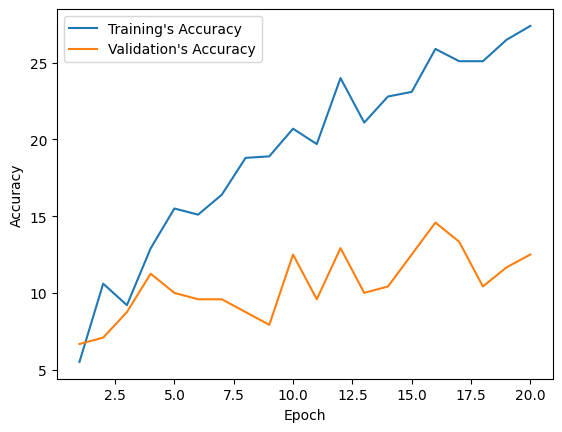

In [260]:
plt.plot([i + 1 for i in range(epochs)], training_accuracies, label="Training\'s Accuracy")
if validationRatio > 0:
    plt.plot([i + 1 for i in range(epochs)], validation_accuracies, label="Validation\'s Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()
if save_details:
    plt.savefig(f"{root}/accuracy_plot.jpg", bbox_inches='tight')
plt.show()


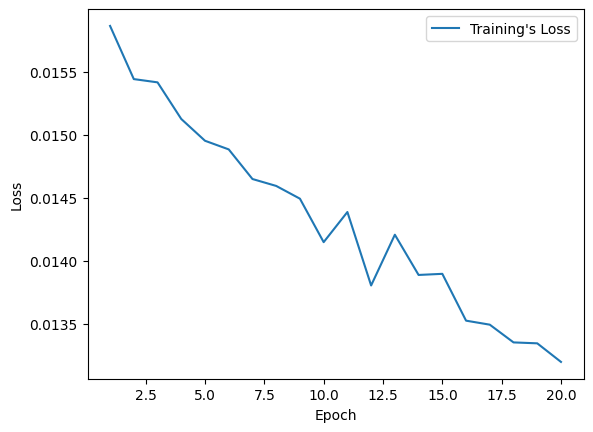

In [261]:
plt.plot([i + 1 for i in range(epochs)], losses, label="Training\'s Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
if save_details:
    plt.savefig(f"{root}/training_loss_plot.jpg", bbox_inches='tight')
plt.show()


In [262]:
post_w = network.layers[0].w.clone()
post_w_decoder = network.decoder[0].weight.clone()

print(f'Length of weights\'s delta: {len(t.where(post_w - pre_w != 0.)[0])}')
print(f'Length of decoder weights\'s Delta: {len(t.where(post_w_decoder - pre_w_decoder != 0.)[0])}')


Length of weights's delta: 200704
Length of decoder weights's Delta: 196608


In [263]:
n_rows = 8
n_cols = 8


In [264]:
def stack_images(n_rows, n_cols, _shape, layer_idx, matrix, is_abs = True):
    c = 0
    _stack_images = np.zeros((_shape[0] * n_rows, _shape[1] * n_cols))

    for i in range(n_rows):
        for j in range(n_cols):
            m = matrix[:, c].cpu().numpy().reshape((*_shape, num_channels if layer_idx == 0 else 1)).mean(2)
            if is_abs:
                m = np.abs(m)
            _stack_images[i * _shape[0]: (i + 1) * _shape[0], j * _shape[1]: (j + 1) * _shape[1]] = m
            c += 1
    return _stack_images


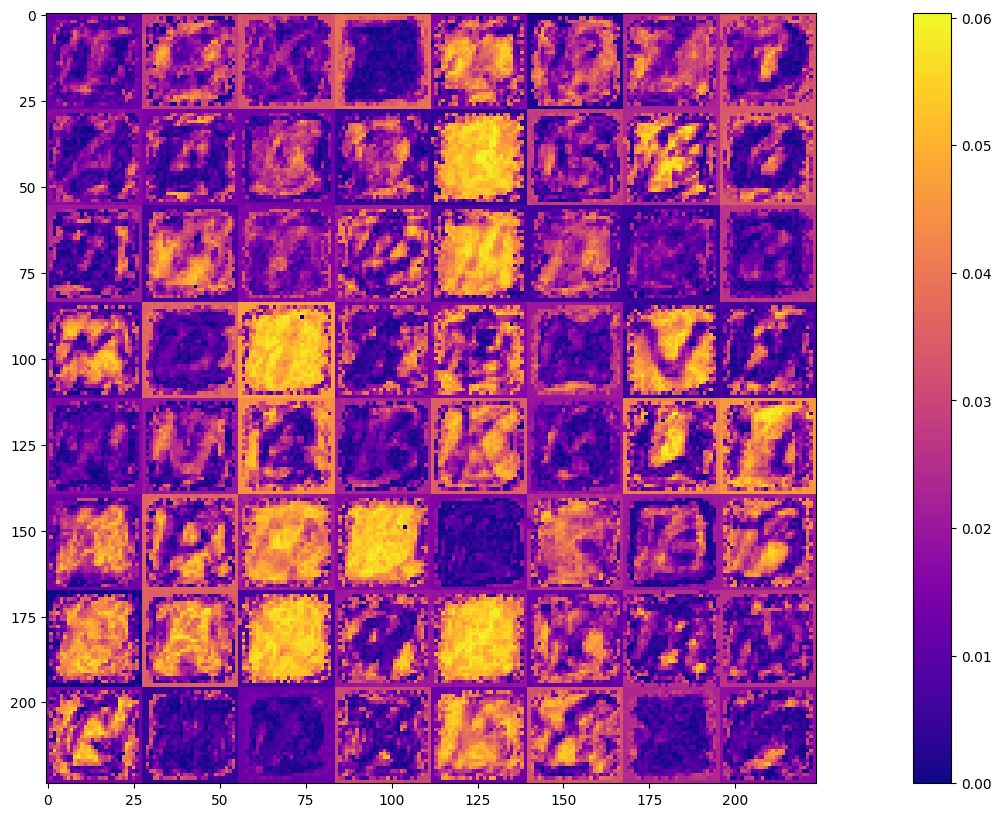

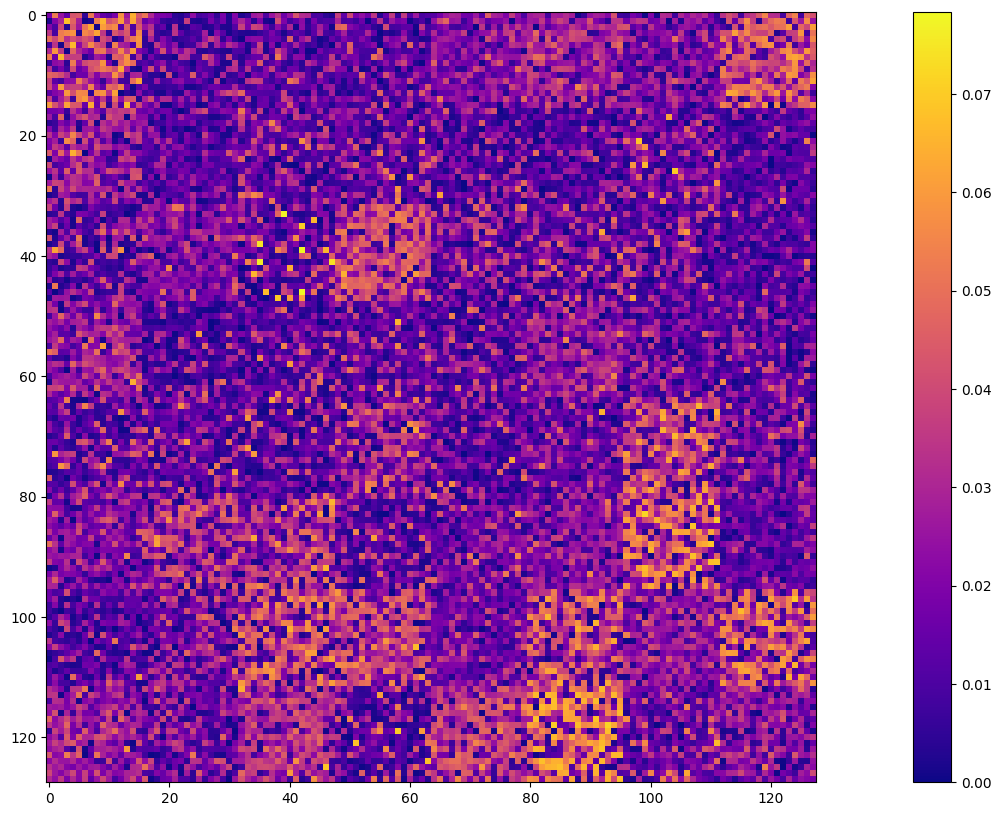

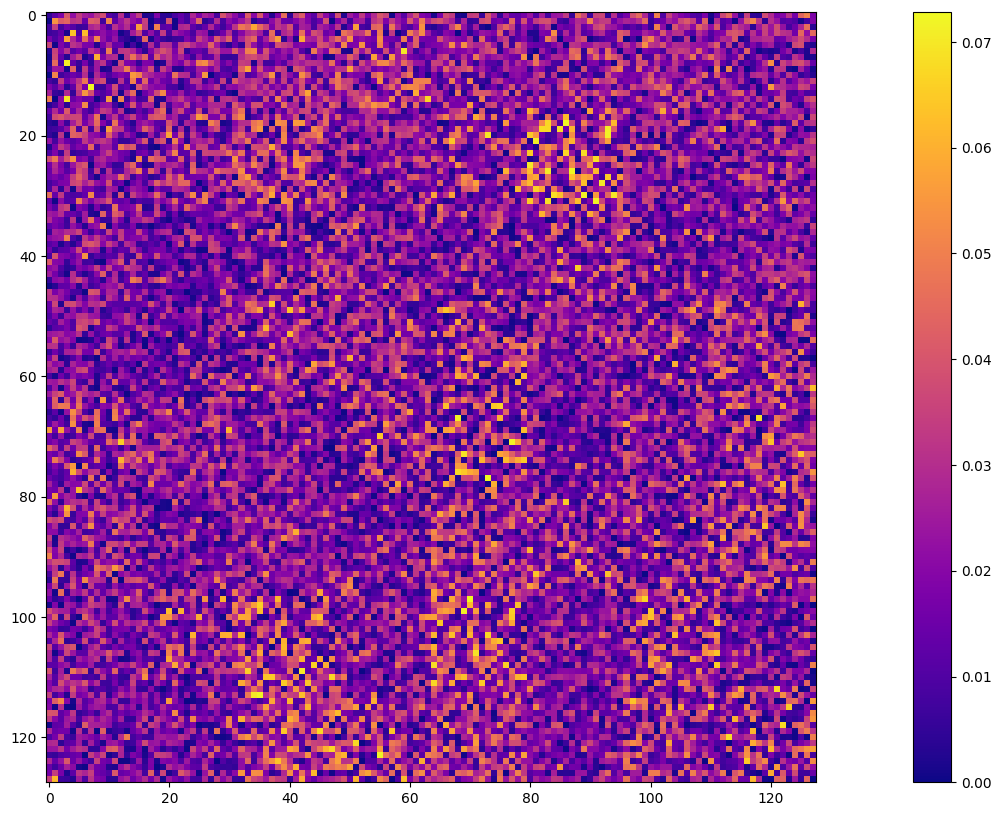

In [265]:
for layer_idx, layer in enumerate(network.layers):
    a = int(np.sqrt(layer.b.shape[0] // (num_channels if layer_idx == 0 else 1)))
    _shape = (a, a)

    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(10)

    stack_h_images = stack_images(n_rows, n_cols, _shape, layer_idx, layer.b)

    plt.imshow(stack_h_images, cmap='plasma')
    plt.colorbar()
    if save_details:
        try:
            os.mkdir(f"{root}/b")
        finally:
            plt.savefig(f"{root}/b/patterns_of_layer_{layer_idx}.jpg", bbox_inches='tight')
    plt.show(block=False)


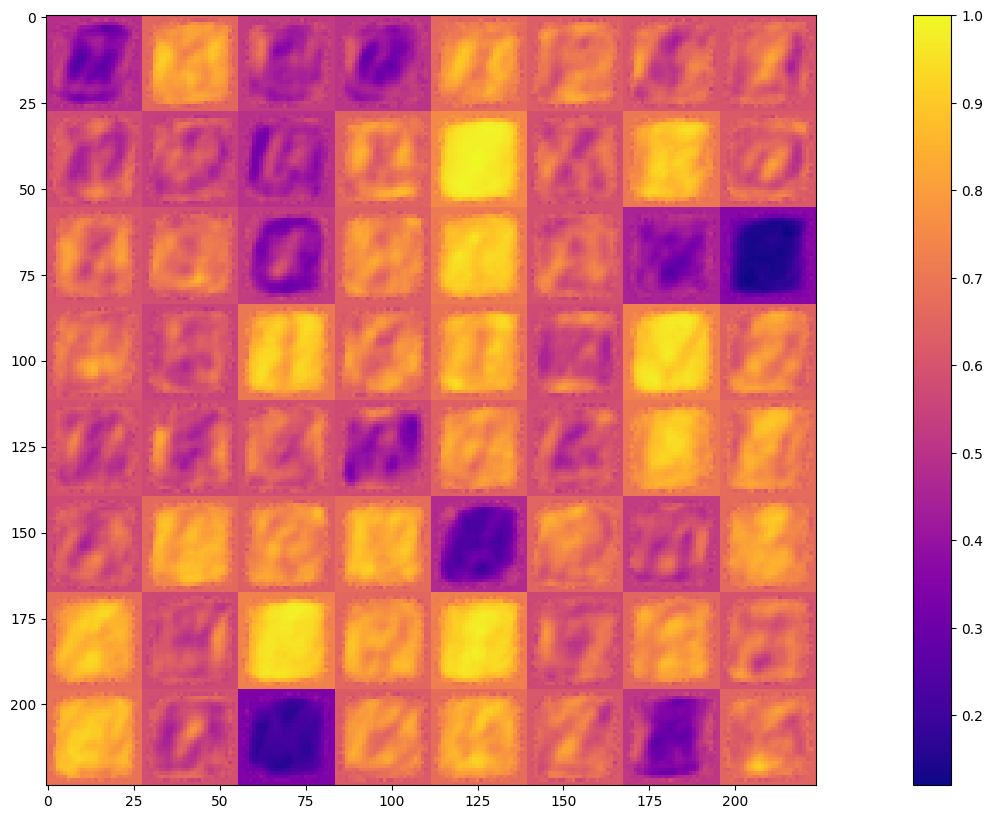

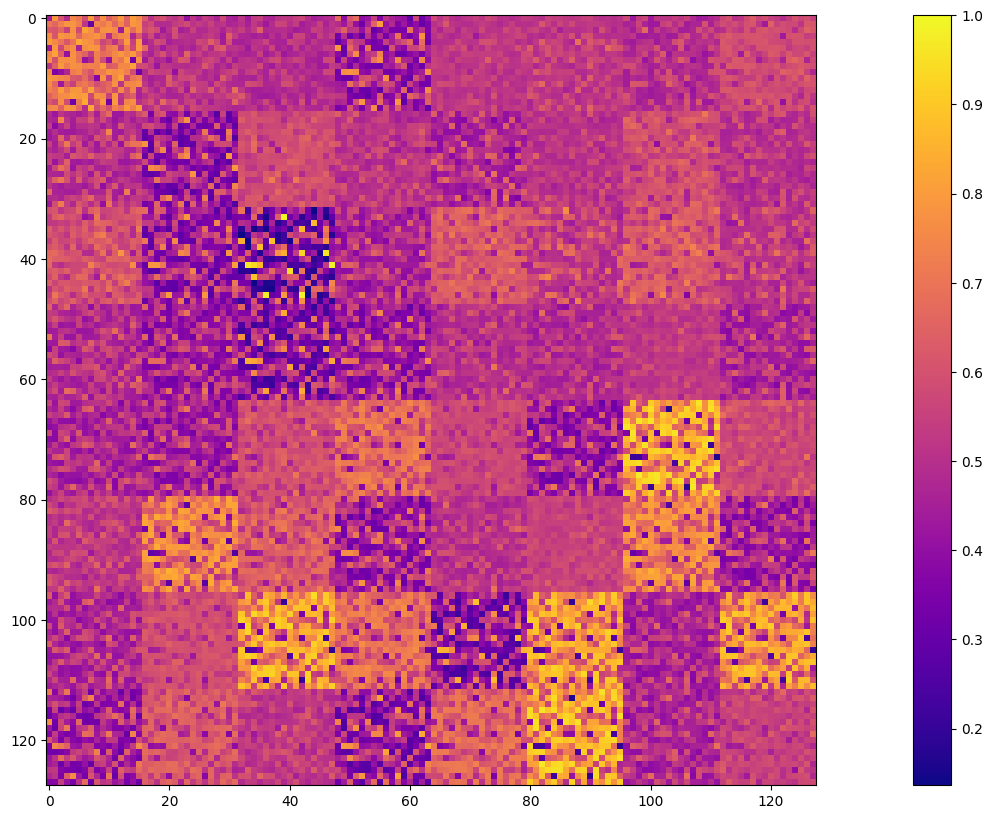

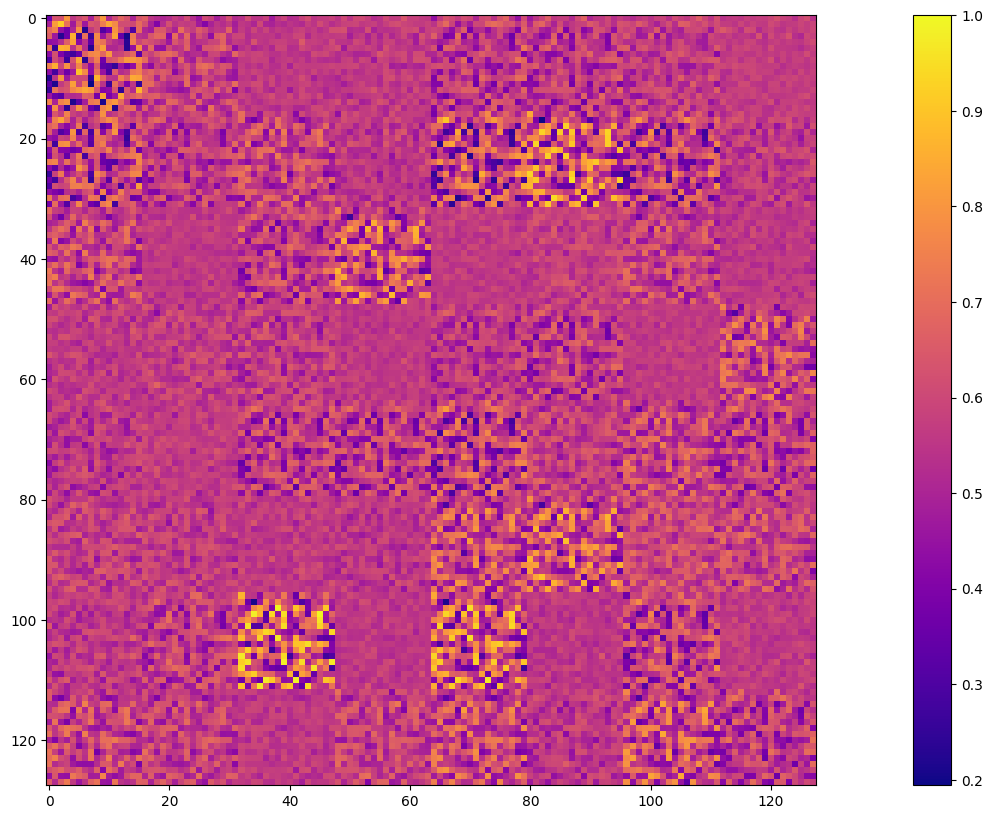

In [266]:
for layer_idx, layer in enumerate(network.layers):
    a = int(np.sqrt(layer.w.shape[0] // (num_channels if layer_idx == 0 else 1)))
    _shape = (a, a)

    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(10)

    stack_w_images = stack_images(n_rows, n_cols, _shape, layer_idx, layer.w)

    plt.imshow(stack_w_images, cmap='plasma')
    plt.colorbar()
    if save_details:
        try:
            os.mkdir(f"{root}/w")
        finally:
            plt.savefig(f"{root}/w/patterns_of_layer_{layer_idx}.jpg", bbox_inches='tight')
    plt.show(block=False)


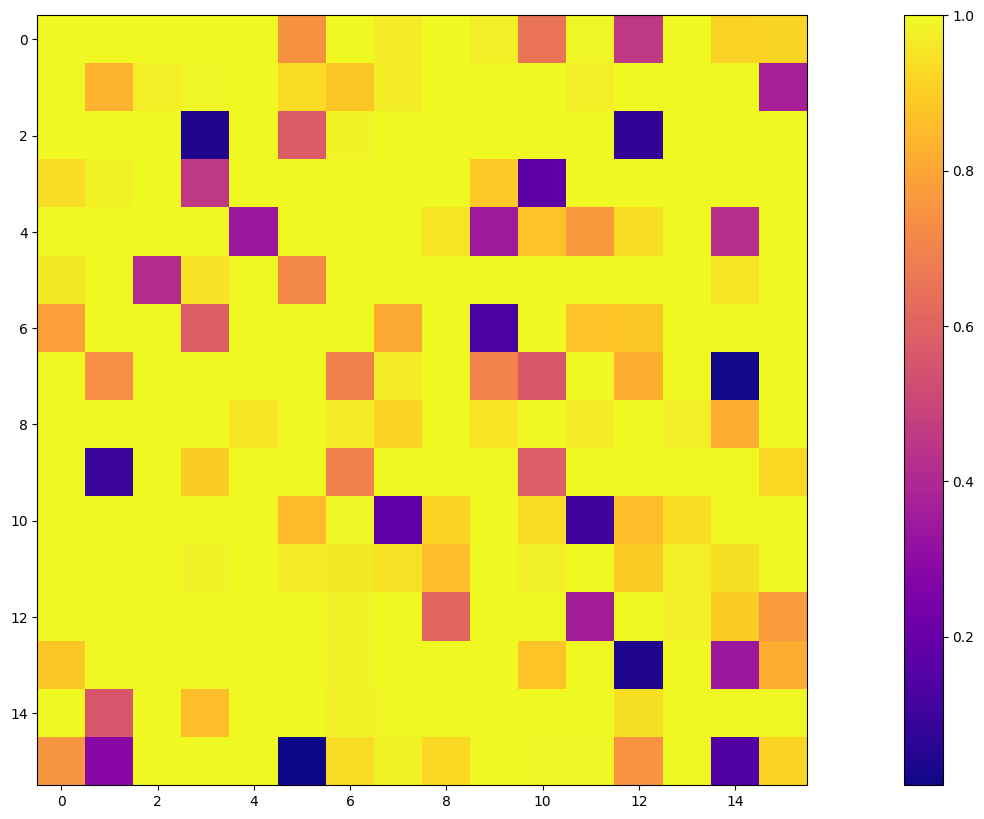

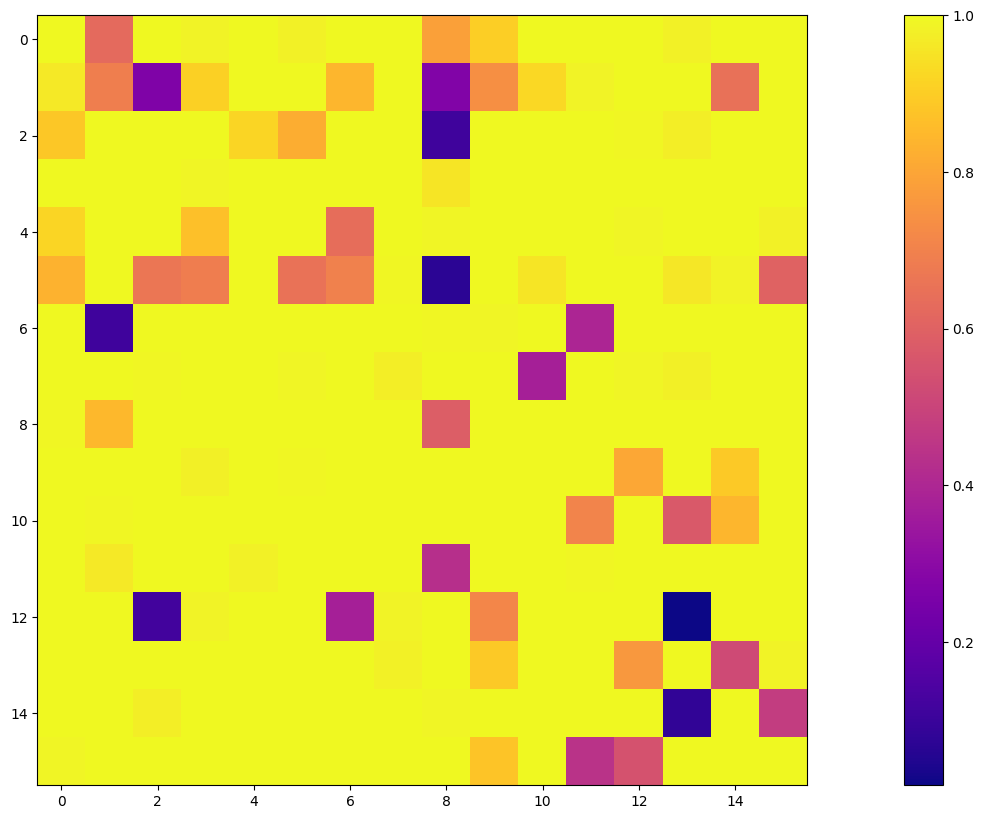

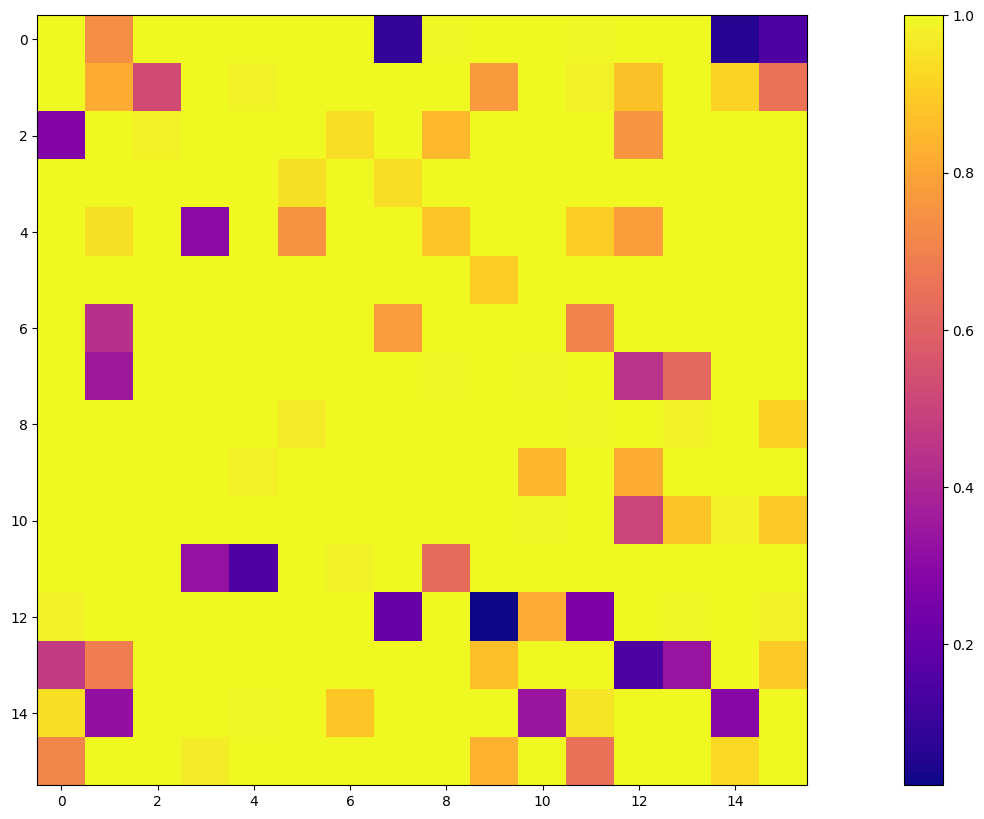

In [267]:
for layer_idx, layer in enumerate(network.layers):
    a = int(np.sqrt(layer.s.shape[1] // (num_channels if layer_idx == 0 else 1)))
    _shape = (a, a)

    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(10)

    plt.imshow(np.abs(layer.s[0].reshape(_shape).cpu().numpy()), cmap='plasma')
    plt.colorbar()
    plt.show(block=False)


In [268]:
corrects = 0
network.eval_(batch_size=evaluating_batch_size)
_tqdm = tqdm(range(len(testSet[0])), desc=f'Evaluating Accuracy: 0.0%: ', colour='green')
samples_per_classes = np.zeros((num_classes))

confusion_matrix = t.zeros((num_classes, num_classes))
for batch_index in _tqdm:
    u = testSet[0][batch_index]
    v = testSet[1][batch_index]

    network.clear_memo()
    p, _ = network.forward(u, v)

    for x, y in zip(p, v):
        x = int(t.argmax(x))
        y = int(t.argmax(y))
        confusion_matrix[x, y] += 1
        samples_per_classes[y] += 1

    corrects += (t.argmax(p, dim=1) == t.argmax(v, dim=1)).sum()
    validation_accuracy = corrects * 100. / (evaluating_batch_size * len(testSet[0]))
    _tqdm.set_description(f'Accuracy: {validation_accuracy:.2f}%')


Accuracy: 13.13%: 100%|██████████| 5816/5816 [01:19<00:00, 73.17it/s]


In [269]:
confusion_matrix = confusion_matrix.cpu().numpy().astype(np.int32)

if save_details:
    confusion_matrix_filepath = f"{root}/confusion_matrix.txt"
    with open(confusion_matrix_filepath, "w+"):
        np.savetxt(confusion_matrix_filepath, confusion_matrix)


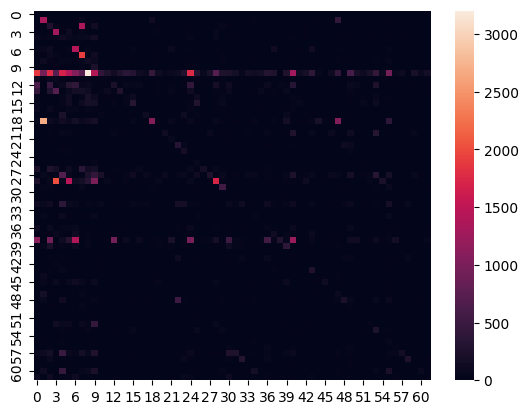

In [270]:
sns.heatmap(confusion_matrix)
if save_details:
    plt.savefig(f"{root}/confusion_matrix.jpg", bbox_inches='tight')


In [271]:
samples_per_classes = samples_per_classes.astype(np.int32)

if save_details:
    spc_filepath = f"{root}/samples_distribution_per_classes.txt"
    with open(spc_filepath, "w+"):
        np.savetxt(spc_filepath, samples_per_classes)


In [272]:
diag = np.diag(confusion_matrix).astype(np.int32)
print(diag)


[   5 1318  275 1301  132    0 1420 1905  149  228  404   17  225  269
   46  335    4  120 1075    2  118   69  320  176    0   58  151  246
 1706  531    1   16  115    3   38    0   39  139  291  386    0    3
    1  267   17  122    0   98  217   27    0    6   34  262    0   51
   27  158  243    0   82   20]


In [273]:
accuracy_per_classes = np.round((diag / samples_per_classes) * 100., 2)
print(accuracy_per_classes)


[9.000e-02 2.082e+01 4.690e+00 2.180e+01 2.350e+00 0.000e+00 2.489e+01
 3.103e+01 2.650e+00 4.010e+00 3.804e+01 2.620e+00 1.294e+01 3.453e+01
 5.410e+00 2.326e+01 8.900e-01 2.303e+01 5.249e+01 3.200e-01 3.089e+01
 8.520e+00 2.155e+01 1.303e+01 0.000e+00 4.150e+00 3.656e+01 3.041e+01
 4.863e+01 3.369e+01 5.000e-02 2.010e+00 1.427e+01 6.900e-01 4.760e+00
 0.000e+00 2.370e+00 1.630e+01 6.736e+01 2.294e+01 0.000e+00 7.500e-01
 1.700e-01 1.805e+01 3.980e+00 3.849e+01 0.000e+00 3.870e+00 4.677e+01
 1.420e+00 0.000e+00 1.630e+00 6.730e+00 1.129e+01 0.000e+00 1.720e+00
 5.600e+00 3.376e+01 5.203e+01 0.000e+00 2.152e+01 4.430e+00]


In [274]:
where_less_than_50 = np.where(accuracy_per_classes < 50.)[0]
print(f'- Indices of Where Classes Are < 50%:\n{where_less_than_50}')
print(f'- Precision of Classes That Are < 50%:\n{accuracy_per_classes[where_less_than_50]}')
print(f'- Number of Classes That Has Accuracy < 50%: {len(where_less_than_50)} / {num_classes}')


- Indices of Where Classes Are < 50%:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 59 60 61]
- Precision of Classes That Are < 50%:
[ 0.09 20.82  4.69 21.8   2.35  0.   24.89 31.03  2.65  4.01 38.04  2.62
 12.94 34.53  5.41 23.26  0.89 23.03  0.32 30.89  8.52 21.55 13.03  0.
  4.15 36.56 30.41 48.63 33.69  0.05  2.01 14.27  0.69  4.76  0.    2.37
 16.3  22.94  0.    0.75  0.17 18.05  3.98 38.49  0.    3.87 46.77  1.42
  0.    1.63  6.73 11.29  0.    1.72  5.6  33.76  0.   21.52  4.43]
- Number of Classes That Has Accuracy < 50%: 59 / 62
